# Lab 8 
## Quesiton 1

### 1. Load the pre-trained VGG16 convolutional neural network model without the output layer. Check-out the summary of the model.  How many layers have been used in the model?  How many parameters needed to be optimized?

In [1]:
from keras import applications

# build the VGG16 network
model = applications.VGG16(include_top=False,
                           weights='imagenet')

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

Using TensorFlow backend.


In [2]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

### 2. We  will  look  into  the  behavior  of  a  specific  layer  of  the  network.  Select  the  1st  filter  of the 3rd convolutional layer of the 5th block of the network as the filter of interest.  You can look through the demo for this part.  Feed a gray image with random noise to the filter and perform gradient ascent for 20 times with the learning rate μ= 1.0.  Plot the output image.

In [3]:
# dimensions of the generated pictures for each filter.
img_width = 128
img_height = 128

# this is the placeholder for the input images
input_img = model.input


In [4]:
from keras import backend as K

layer_name = 'block5_conv1'
filter_index = 0  # can be any integer from 0 to 511, as there are 512 filters in that layer

# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
loss = K.mean(layer_output[:, :, :, filter_index])

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

In [5]:
import numpy as np

# we start from a gray image with some noise
input_img_data = np.random.random((1, img_width, img_height, 3))
input_img_data = (input_img_data - 0.5) * 20 + 128
# run gradient ascent for 20 steps
step = 1.
for i in range(20):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step
    print('Current loss value:', loss_value)

('Current loss value:', 10.901394)
('Current loss value:', 25.148533)
('Current loss value:', 42.48563)
('Current loss value:', 66.626205)
('Current loss value:', 89.688202)
('Current loss value:', 110.21048)
('Current loss value:', 132.41986)
('Current loss value:', 154.98642)
('Current loss value:', 173.39984)
('Current loss value:', 195.80655)
('Current loss value:', 211.73837)
('Current loss value:', 233.93146)
('Current loss value:', 255.17476)
('Current loss value:', 278.22723)
('Current loss value:', 300.61832)
('Current loss value:', 324.0484)
('Current loss value:', 350.17899)
('Current loss value:', 371.86899)
('Current loss value:', 395.29321)
('Current loss value:', 418.16962)


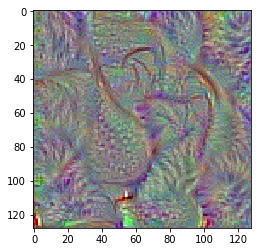

In [6]:
from scipy.misc import imsave
from matplotlib.pyplot import imshow
%matplotlib inline

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x


img = input_img_data[0]
img = deprocess_image(img)
# img.shape
imshow(img)
# imsave('%s_filter_%d.png' % (layer_name, filter_index), img)

### 3. We can extend this part for all of the layers.  Feed a gray image with random noise to the first convolutional layer of each block.  Note that each layer has a different number of filters.  Use the range of 64 filters and plot the 12 results that maximize the activation of the corresponding filter. How are the outputs evolving as we go up in the layers?  Can you find any patterns?  Comment on the results.

In [7]:
layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
n_filters = 64
n_best = 12
keep = {}
for l in layers:
    print(l)
    kept_filters = []
    for filter_index in range(n_filters):
        # we only scan through the first 200 filters,
        # but there are actually 512 of them
        print('Processing filter %d' % filter_index)

        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        layer_output = layer_dict[layer_name].output
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])

        # we compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        # normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])

        # step size for gradient ascent
        step = 1.

        # we start from a gray image with some random noise
        if K.image_data_format() == 'channels_first':
            input_img_data = np.random.random((1, 3, img_width, img_height))
        else:
            input_img_data = np.random.random((1, img_width, img_height, 3))
        input_img_data = (input_img_data - 0.5) * 20 + 128

        # we run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([input_img_data])
            input_img_data += grads_value * step

#             print('Current loss value:', loss_value)
            if loss_value <= 0.:
                # some filters get stuck to 0, we can skip them
                break

        # decode the resulting input image
        if loss_value > 0:
            img = deprocess_image(input_img_data[0])
            kept_filters.append((img, loss_value))
    kept_filters.sort(key=lambda x: x[1], reverse=True)
    kept_filters = kept_filters[:n_best]
    keep[l] = kept_filters

block1_conv1
Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
Processing filter 9
Processing filter 10
Processing filter 11
Processing filter 12
Processing filter 13
Processing filter 14
Processing filter 15
Processing filter 16
Processing filter 17
Processing filter 18
Processing filter 19
Processing filter 20
Processing filter 21
Processing filter 22
Processing filter 23
Processing filter 24
Processing filter 25
Processing filter 26
Processing filter 27
Processing filter 28
Processing filter 29
Processing filter 30
Processing filter 31
Processing filter 32
Processing filter 33
Processing filter 34
Processing filter 35
Processing filter 36
Processing filter 37
Processing filter 38
Processing filter 39
Processing filter 40
Processing filter 41
Processing filter 42
Processing filter 43
Processing filter 44
Processing filter 45
Processing filter 46
Processing

('block1_conv1', 1456.4043)


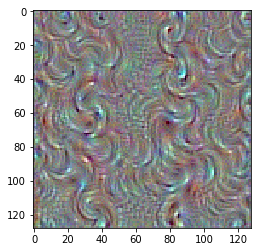

('block1_conv1', 1374.9131)


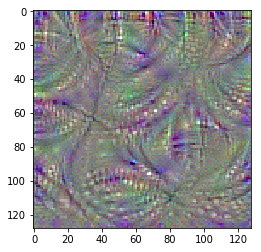

('block1_conv1', 1322.4485)


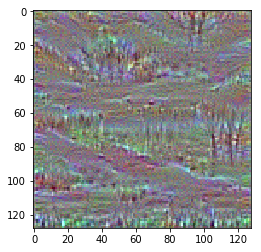

('block1_conv1', 1293.7444)


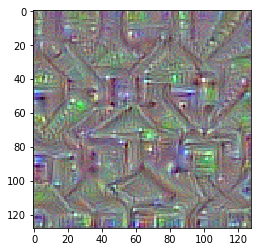

('block1_conv1', 1281.5481)


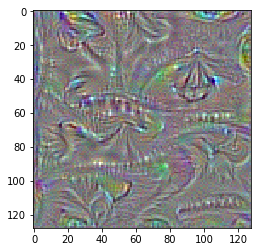

('block1_conv1', 1275.7363)


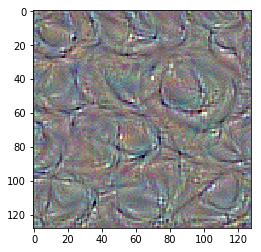

('block1_conv1', 1241.7177)


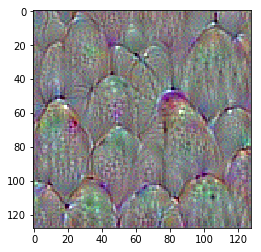

('block1_conv1', 1229.2563)


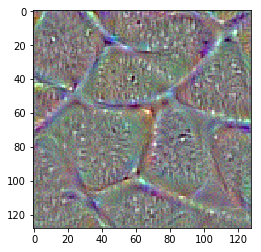

('block1_conv1', 1208.1028)


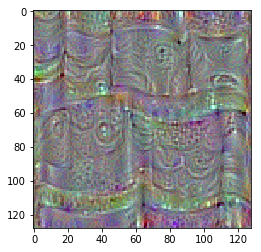

('block1_conv1', 1190.3665)


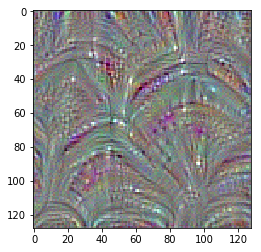

('block1_conv1', 1174.8861)


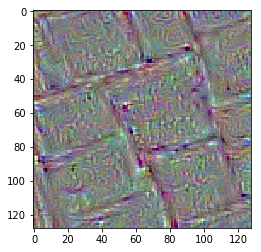

('block1_conv1', 1156.6318)


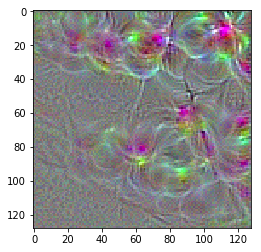

('block2_conv1', 1445.7869)


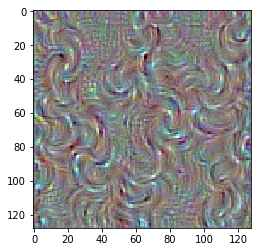

('block2_conv1', 1388.454)


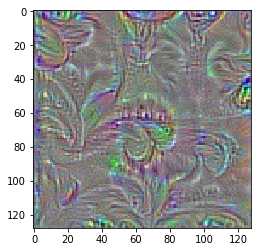

('block2_conv1', 1345.7198)


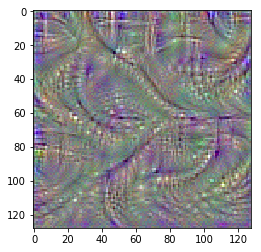

('block2_conv1', 1342.1305)


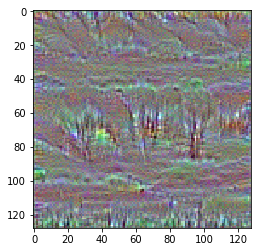

('block2_conv1', 1272.4242)


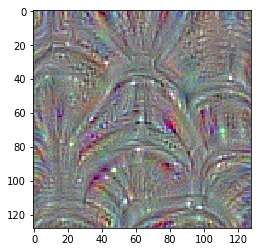

('block2_conv1', 1258.4923)


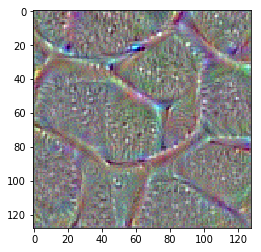

('block2_conv1', 1251.3259)


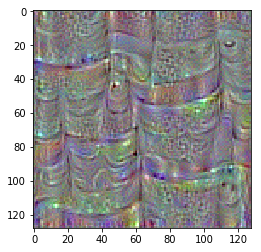

('block2_conv1', 1231.3638)


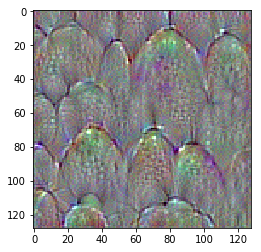

('block2_conv1', 1209.2653)


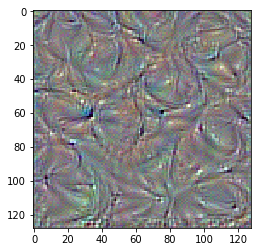

('block2_conv1', 1185.0184)


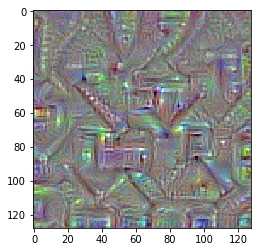

('block2_conv1', 1156.0331)


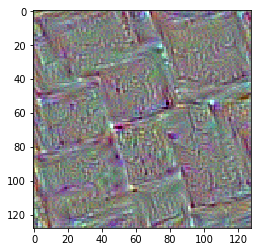

('block2_conv1', 1109.7946)


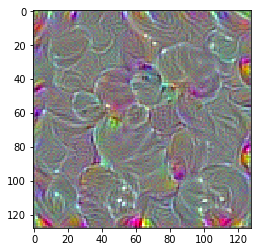

('block3_conv1', 1427.6971)


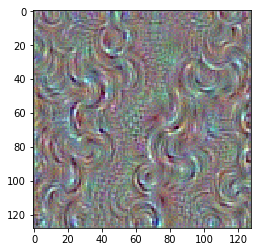

('block3_conv1', 1375.0432)


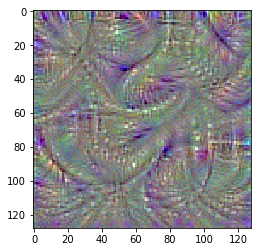

('block3_conv1', 1359.2673)


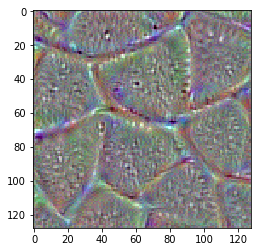

('block3_conv1', 1356.4467)


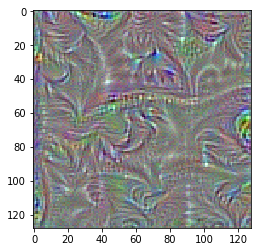

('block3_conv1', 1354.4308)


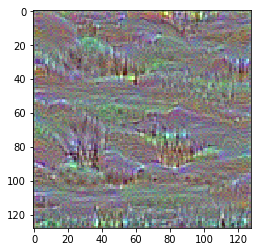

('block3_conv1', 1295.1766)


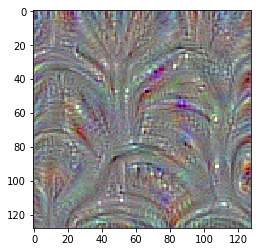

('block3_conv1', 1257.5566)


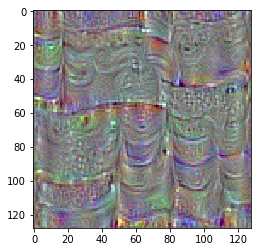

('block3_conv1', 1232.8607)


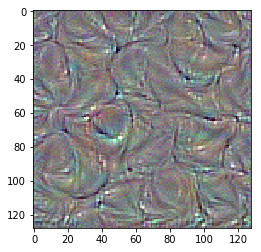

('block3_conv1', 1224.2048)


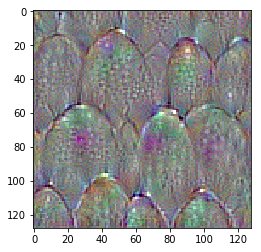

('block3_conv1', 1193.5471)


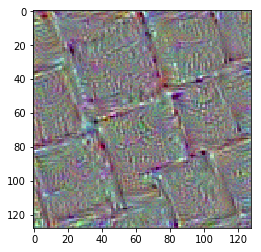

('block3_conv1', 1168.561)


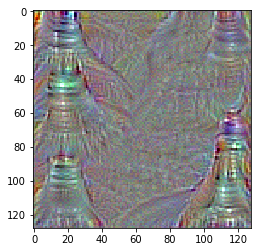

('block3_conv1', 1150.0623)


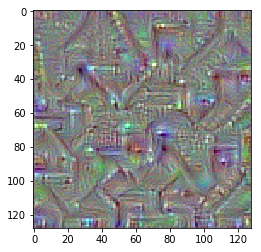

('block4_conv1', 1422.1403)


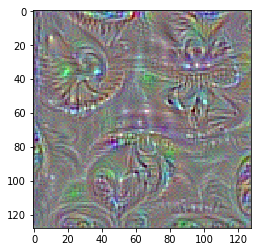

('block4_conv1', 1409.1835)


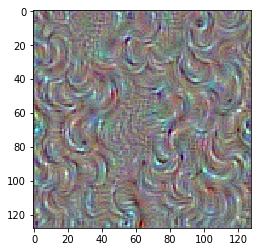

('block4_conv1', 1346.2062)


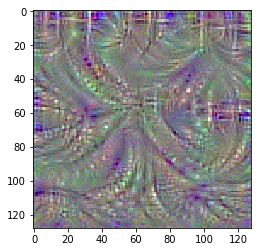

('block4_conv1', 1283.0966)


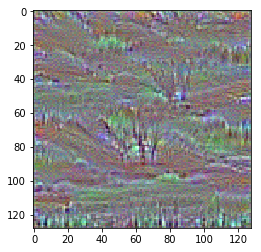

('block4_conv1', 1267.9158)


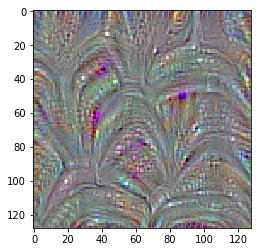

('block4_conv1', 1267.6799)


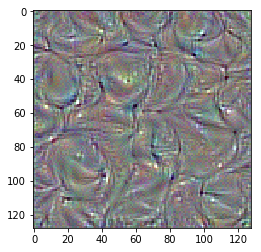

('block4_conv1', 1258.47)


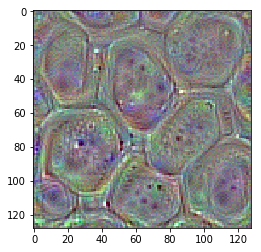

('block4_conv1', 1246.3466)


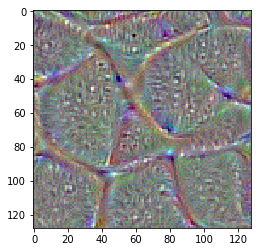

('block4_conv1', 1245.9436)


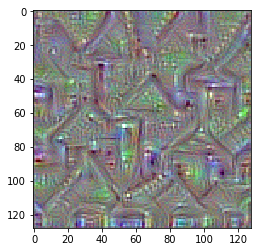

('block4_conv1', 1192.9244)


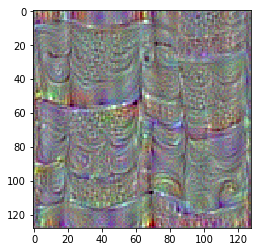

('block4_conv1', 1190.9385)


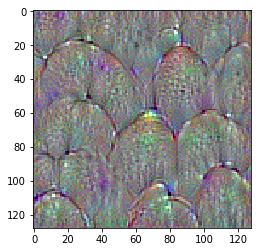

('block4_conv1', 1168.7986)


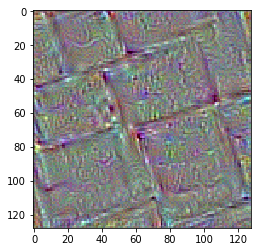

('block5_conv1', 1413.4155)


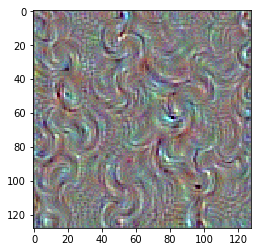

('block5_conv1', 1361.8621)


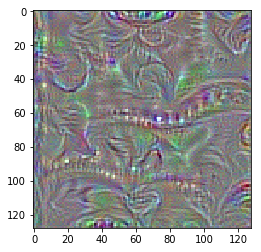

('block5_conv1', 1357.7921)


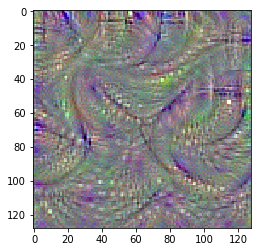

('block5_conv1', 1326.4277)


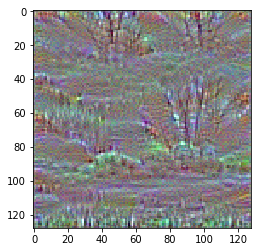

('block5_conv1', 1315.4465)


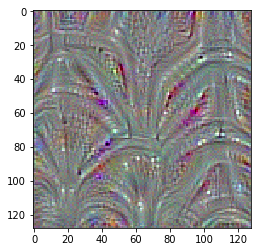

('block5_conv1', 1271.3386)


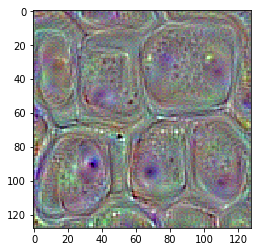

('block5_conv1', 1237.1433)


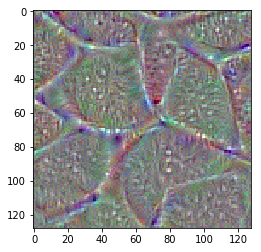

('block5_conv1', 1225.8142)


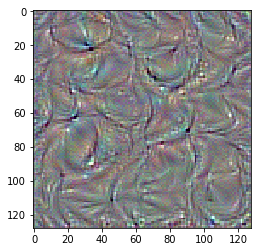

('block5_conv1', 1199.9448)


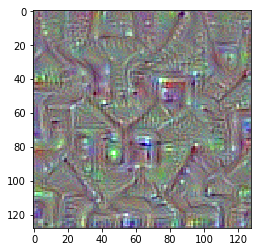

('block5_conv1', 1192.7694)


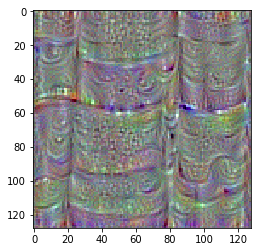

('block5_conv1', 1186.3669)


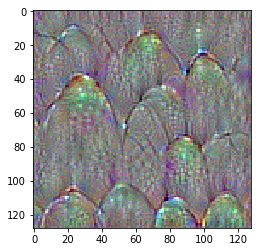

('block5_conv1', 1142.0972)


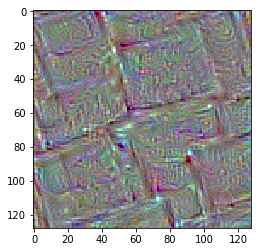

In [8]:
from matplotlib.pyplot import show
for filt in layers:
    for im,loss in keep[filt]:
        print (filt,loss)
        imshow(im)
        show()

### 4. We do not have to feed a random image.  Feed an actual image of your choosing to the filter we used in the first part.  Again, use gradient ascent for 20 times and plot the output image.

In [9]:
from keras import backend as K

layer_name = 'block5_conv1'
filter_index = 0  # can be any integer from 0 to 511, as there are 512 filters in that layer

# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
loss = K.mean(layer_output[:, :, :, filter_index])

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

In [10]:
from scipy.misc import imread

# we start from a gray image with some noise
input_img_data = imread('cat2.jpg')
input_img_data = input_img_data.reshape((1, img_width, img_height, 3)).astype('float32')
# input_img_data = (np.random.random((1, img_width, img_height, 3)) - 0.5) * 20 + 128
# print input_img_data
# run gradient ascent for 20 steps
step = 1.
for i in range(20):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step
    print('Current loss value:', loss_value)

('Current loss value:', 36.167568)
('Current loss value:', 85.12133)
('Current loss value:', 130.83963)
('Current loss value:', 176.76019)
('Current loss value:', 220.32553)
('Current loss value:', 269.94226)
('Current loss value:', 326.50583)
('Current loss value:', 384.57809)
('Current loss value:', 437.26889)
('Current loss value:', 488.65796)
('Current loss value:', 538.52795)
('Current loss value:', 590.10693)
('Current loss value:', 641.44055)
('Current loss value:', 689.52686)
('Current loss value:', 736.27875)
('Current loss value:', 781.7182)
('Current loss value:', 825.88544)
('Current loss value:', 870.87732)
('Current loss value:', 915.25317)
('Current loss value:', 957.97583)


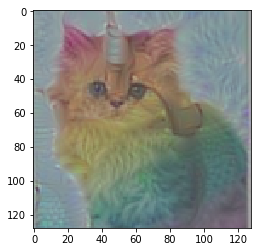

In [11]:
img = input_img_data[0]
img = deprocess_image(img)
# img.shape
imshow(img)
# imsave('%s_filter_%d.png' % (layer_name, filter_index), img)

### 5. Now,  we will look into how the network is classifying the images.  For this part,  we also need the output layer of the network.  Load VGG convolutional network with the output layer this time.  We first use output index= 65 which corresponds to ’Sea Snake’ class in ImageNet.  Feed a gray image with random noise to the filter corresponding to the specified output index.  Perform gradient  ascent  20  times  and  report  the  loss  at  each  step.   How  sure  your  network  is  about  the image being a sea snake?  Plot the output image.  Does it look like a sea snake?  Why did network decide that it is a sea snake with the corresponding probability?  Comment on the results.

In [12]:
# build the VGG16 network
model = applications.VGG16(include_top=True,
                           weights='imagenet')

# this is the placeholder for the input images
input_img = model.input

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [57]:
img_width = 224
img_height = 224

def show_filter_output(model,output_index,step=1):
    loss = K.mean(model.output[:, output_index])

    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
        print('Current loss value:', loss_value)
    img = deprocess_image(input_img_data[0])
    imshow(img)
    show()

('Current loss value:', 0.00033432359)
('Current loss value:', 0.00033749445)
('Current loss value:', 0.00034079375)
('Current loss value:', 0.00034414197)
('Current loss value:', 0.00034755247)
('Current loss value:', 0.00035100995)
('Current loss value:', 0.00035450561)
('Current loss value:', 0.00035804269)
('Current loss value:', 0.000361663)
('Current loss value:', 0.00036535726)
('Current loss value:', 0.00036915115)
('Current loss value:', 0.00037297746)
('Current loss value:', 0.00037676166)
('Current loss value:', 0.00038065476)
('Current loss value:', 0.00038458334)
('Current loss value:', 0.00038854612)
('Current loss value:', 0.00039260316)
('Current loss value:', 0.00039660858)
('Current loss value:', 0.00040064091)
('Current loss value:', 0.00040475896)


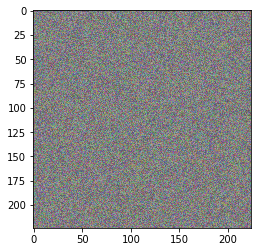

('Current loss value:', 0.00040389603)
('Current loss value:', 0.00043436416)
('Current loss value:', 0.00046584097)
('Current loss value:', 0.00049973786)
('Current loss value:', 0.00054107094)
('Current loss value:', 0.00059792143)
('Current loss value:', 0.00067957671)
('Current loss value:', 0.00081900769)
('Current loss value:', 0.0010884849)
('Current loss value:', 0.0015982941)
('Current loss value:', 0.0037622349)
('Current loss value:', 0.03470365)
('Current loss value:', 0.015641658)
('Current loss value:', 0.51191902)
('Current loss value:', 0.37868729)
('Current loss value:', 0.55328679)
('Current loss value:', 0.0095406109)
('Current loss value:', 0.99766076)
('Current loss value:', 0.9991861)
('Current loss value:', 0.9994148)


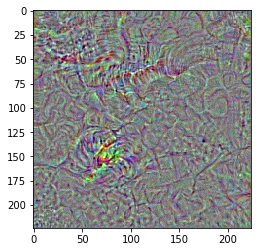

In [60]:
show_filter_output(model,65)
show_filter_output(model,65,step=8)

### 6.Change the output index we used to output index= 18, which corresponds to ’Magpie’ class in ImageNet.  Perform the same tasks as in part 5.  Report the losses and plot the output image. How sure your network is about the image belonging to this class?  Does the output look like a magpie?  Comment on the results.

('Current loss value:', 0.0042376318)
('Current loss value:', 0.0053033833)
('Current loss value:', 0.0066708075)
('Current loss value:', 0.008157583)
('Current loss value:', 0.0096032852)
('Current loss value:', 0.010967461)
('Current loss value:', 0.01235752)
('Current loss value:', 0.013863963)
('Current loss value:', 0.015513211)
('Current loss value:', 0.017155414)
('Current loss value:', 0.018839663)
('Current loss value:', 0.02069784)
('Current loss value:', 0.022701947)
('Current loss value:', 0.02495103)
('Current loss value:', 0.027796762)
('Current loss value:', 0.031386517)
('Current loss value:', 0.035616126)
('Current loss value:', 0.040598221)
('Current loss value:', 0.046894152)
('Current loss value:', 0.054638732)


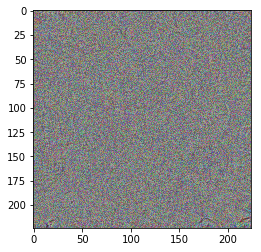

('Current loss value:', 0.004234842)
('Current loss value:', 0.0093036126)
('Current loss value:', 0.014579015)
('Current loss value:', 0.021356106)
('Current loss value:', 0.024310984)
('Current loss value:', 0.03286792)
('Current loss value:', 0.044686701)
('Current loss value:', 0.064639516)
('Current loss value:', 0.065231331)
('Current loss value:', 0.083328351)
('Current loss value:', 0.016674113)
('Current loss value:', 0.10829355)
('Current loss value:', 0.014747478)
('Current loss value:', 0.35905358)
('Current loss value:', 0.014101528)
('Current loss value:', 0.4662244)
('Current loss value:', 0.35222864)
('Current loss value:', 0.55313092)
('Current loss value:', 0.92146456)
('Current loss value:', 0.99909878)


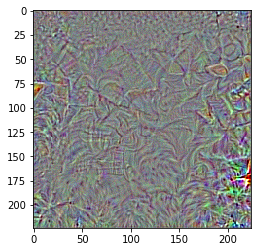

In [63]:
show_filter_output(model,18)
show_filter_output(model,18,step=8)